## Read Data (replies already been excluded)

In [1]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
import pandas as pd

text = pd.read_csv('Jan6(excludes replies).csv')
print('The number of tweets (excludes replies) before data pre-processing:',len(text))

The number of tweets (excludes replies) before data pre-processing: 6501


## Data Pre-processing

In [2]:
import gensim
import gensim.corpora as corpora
import re
porter = PorterStemmer()
stop_words = stopwords.words('english')
b = []
for i,u in text.iterrows():
    a = []
    word =''
    for words in str(u['tweets']).split(): #tokenization
        if '@' not in words: #remove @users
            words = words.replace('#','') #remove hashtag symbol
            if '#' not in words:
                if 'http' not in words: #remove URLs
                    if'&amp' not in words: #remove symbol
                        words = re.sub(r'[^a-zA-Z]', ' ', words)
                        words = words.lower()# lower form
                        #words = re.sub(r'[^a-zA-Z]', ' ', words) #remove non-alphabetic characters
                        if len(words)>2:
                            word += (words+' ')
    doc = ''
    for token in word.split():
        if len(token) >2: # remove words that have less than 3 characters
            if token not in stop_words:# remove stopwords
                token = porter.stem(token) #stemming
                doc += (token+' ')
    b.append(doc)
text['processed']=[i for i in b]

# exclude tweets that are not in English
non_english_list = ['temiz','rkiy','erik','nda','konu','dan','da','ba','temiz','al','viand','para','na','dann','uft','laboratorio','dieser','kalbimi',
                   'restoranda','evento','komo','ind','tica','futuro','sonra','yla','cre','ili','daki',
                   'zaman']
index_axis = []
for index,i in text.iterrows():
    if len(i['processed']) == 0:
        index_axis.append(index)
    else:
        for word in i['processed'].split():
            if word in non_english_list:
                index_axis.append(index)
                break
text.drop(text.index[index_axis],inplace=True)
print("number of tweets after cleaning:",len(text))

number of tweets after cleaning: 6248


### Number of tweets from each company after pre-processing:

In [3]:
text.groupby('Company')['tweets'].count().sort_values(ascending=False)

Company
Memphis Meats       1545
biftek.co 🔬👩‍🔬🐄🥗    1429
Aleph Farms          704
Finless Foods        516
shiokmeats           463
SuperMeat            315
New Age Meats        306
BlueNalu             273
CUBIQ FOODS          243
Meatable             114
Mosa Meat            108
Wildtype              89
Future Fields         44
Vow                   36
FutureMeat            32
Balletic Foods        25
Mission Barns          2
LabFarmFoods           2
Avant Meats            2
Name: tweets, dtype: int64

## GuidedLDA

In [4]:
import guidedlda
import numpy as np
seed_topic_list = [['environ','carbon','greenhous','futur','emiss','better','planet','save','reduc',
                   'system','land','plastic','sustain','climat','environment','climatechang'], #0 Environmental Impact
                   ['plant','vegan','vegetarian','anim','altern','protein','plantbas'], #1 Vegetarian
                   ['without','harm','slaughter','cruelti','welfar','kill','cow','human','farm','save','free','anim'],#2 Animal Welfare
                   ['consumpt','popul','demand','secur','wast','grow','global','sustain','need',
                   'consum','eat','growth','feed','solut'],#3 Food Security
                   ['antibiot','antimicrobi','resist','contamin','safe','free','overus',
                   'metal','bacteria'],#4 Food Safety
                   ['regulatori','usda','fda','safe','joint','label','regul','clariti'],#5 Regulations
                   ['industri','suppli','convent','system','chain','compani',
                    'market','consum','store','groceri','product','demand','grow','launch','scale','cost','sell'],#6 Food Industry & Market
                   ['seafood','ocean','fish','aquacultur','shrimp','salmon','wild','lobster','tuna','sushi','crustacean'],#7 Seafood
                   ['chicken','duck','poultri','burger','steak','meatbal','beef','sausag',
                    'tast','tender','textur','juici','test','delici','tasti'],#8 Poultry and Meat
                   ['stem','muscl','divis','biolog','cellular','technolog','agricultur','biotech','tech'],#9 Process
                   ['seri','fund','rais','invest','dollar','pound','round','startup',
                   'opportun','first','seed','isra','acceler','announc','happi','thrill','excit','pleas','contribut','honor','proud','statement'],#10 Fundraising Announcement
                   ['thank','support','shoutout','help','question','mention'],#11 Appreciation
                   ['confer','regist','live','symposium','stream','livestream','summit','founder','talk','speak','ceo'], #12 Conference and Summit
                   ['hire','join','team','bring','welcom','work','appli','research','specialist','student','career','posit'],#13 Hiring Information
                   ['congrat','congratul','list','award','winner','finalist','partner','prize'],#14 Congratulations
                   ['check','post','paper','interview','articl','blog','news','break','read',
                   'latest','watch','podcast','listen','episod','stori','coverag','campaign','video','discuss',
                    'chat','report','ceo','media','present']]#15 Media

from sklearn.feature_extraction.text import CountVectorizer
model = guidedlda.GuidedLDA(n_topics=19,n_iter=1000,random_state=5,refresh=10,alpha=0.01,eta=0.01)#5 ok, try some other random seed
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text['processed'])

vocab = vectorizer.get_feature_names()
word2id = dict((v,idx) for idx,v in enumerate(vocab))
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

model.fit(X.toarray(),seed_topics=seed_topics,seed_confidence=0.7) #set seed confidence to 0.7
topic_word = model.topic_word_
n_top_words = 30
vocab = tuple(vocab)

for i, topic_dist in enumerate(topic_word): #Print out results
    print('\n')
    print('Topic:',i)
    words_probability = np.array(-topic_dist)
    for index in range(n_top_words):
        print(round(abs(np.sort(words_probability))[:(n_top_words)][index],4),'*',
              np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1][index],sep='',end='  ')
        

INFO:guidedlda:n_documents: 6248
INFO:guidedlda:vocab_size: 7520
INFO:guidedlda:n_words: 74569
INFO:guidedlda:n_topics: 19
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -989832
INFO:guidedlda:<10> log likelihood: -620241
INFO:guidedlda:<20> log likelihood: -605448
INFO:guidedlda:<30> log likelihood: -599544
INFO:guidedlda:<40> log likelihood: -594246
INFO:guidedlda:<50> log likelihood: -592309
INFO:guidedlda:<60> log likelihood: -590347
INFO:guidedlda:<70> log likelihood: -588687
INFO:guidedlda:<80> log likelihood: -587512
INFO:guidedlda:<90> log likelihood: -586511
INFO:guidedlda:<100> log likelihood: -585045
INFO:guidedlda:<110> log likelihood: -584350
INFO:guidedlda:<120> log likelihood: -583695
INFO:guidedlda:<130> log likelihood: -583592
INFO:guidedlda:<140> log likelihood: -582877
INFO:guidedlda:<150> log likelihood: -582020
INFO:guidedlda:<160> log likelihood: -582513
INFO:guidedlda:<170> log likelihood: -581906
INFO:guidedlda:<180> log likelihood: -581393
INFO:



Topic: 0
0.0346*meat  0.0269*chang  0.0245*climat  0.0175*food  0.0171*anim  0.0129*world  0.0117*product  0.011*impact  0.0098*reduc  0.0098*eat  0.0094*need  0.0087*emiss  0.0087*use  0.0084*agricultur  0.0082*environment  0.0079*peopl  0.0079*water  0.0079*sustain  0.0075*less  0.0072*environ  0.0072*could  0.007*human  0.0068*consumpt  0.0068*global  0.0065*land  0.0065*produc  0.0063*system  0.0061*way  0.0061*cultur  0.0058*grow  

Topic: 1
0.0489*meat  0.036*plant  0.0352*base  0.0217*year  0.0206*plantbas  0.0203*burger  0.0203*protein  0.0183*food  0.0163*vegan  0.016*market  0.0152*altern  0.0129*new  0.0126*beyond  0.0094*sale  0.0092*billion  0.0089*next  0.008*first  0.0074*could  0.0072*beef  0.0072*futureoffood  0.0069*say  0.0063*via  0.0063*report  0.006*chang  0.006*like  0.006*industri  0.0057*consum  0.0054*imposs  0.0054*big  0.0054*go  

Topic: 2
0.1074*meat  0.0542*anim  0.0292*without  0.0237*make  0.0166*slaughter  0.0164*eat  0.0162*real  0.016*better  0.016

## Categorize Tweets according to their most salient topic

In [5]:
doc_topic = model.transform(X)
topic_number = []
number = []

for i in range(len(doc_topic)):
    topic_number.append(doc_topic[i].argmax())
    number.append('1')
data = pd.DataFrame(data=[i for i in topic_number],columns=['topic_number'])
data['number'] = [i for i in number]
number_of_tweets = pd.DataFrame(data.groupby('topic_number')['number'].count())
number_of_tweets['proportion'] = [str(round(i/len(text)*100,2))+'%' for i in number_of_tweets['number']]
number_of_tweets

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


,number,proportion
topic_number,,
0,337,5.39%
1,282,4.51%
2,492,7.87%
3,337,5.39%
4,204,3.27%
5,232,3.71%
6,328,5.25%
7,221,3.54%
8,457,7.31%


## Prominent factor

In [6]:
prominent_factor = []
for i in range(len(doc_topic)):
    prominent_factor.append(sorted(doc_topic[i])[-1]/sorted(doc_topic[i])[-2])
count = 0
for i in prominent_factor:
    if i >= 1.4:
        count += 1
print('There are ',round(count/len(text)*100,2),'% of tweets with prominent factor higher or equal to 1.4',sep='',)

There are 79.79% of tweets with prominent factor higher or equal to 1.4


## Topic-Author Analysis

In [7]:
doc_topic = model.transform(X)
topic_number1 = []


for i in range(len(doc_topic)):
    topic_number1.append(doc_topic[i].argmax())
text['topic number'] = [i for i in topic_number1]
topic_author = text.groupby(['topic number','Company'])['tweets'].count()
topic_author_3d = topic_author.unstack()
topic_author_3d = topic_author_3d[['Memphis Meats','biftek.co 🔬👩‍🔬🐄🥗','Aleph Farms','SuperMeat',
                                  'Finless Foods','shiokmeats','BlueNalu','New Age Meats','CUBIQ FOODS',
                                  'Mosa Meat','Wildtype','Meatable','Future Fields','Vow',
                                  'FutureMeat','Balletic Foods','LabFarmFoods','Avant Meats','Mission Barns']]

topic = ['Environmental Impact','Vegetarian and Alternative Protein','Animal Welfare',
        'Food Security', 'Food Safety', 'Regulations','Food Industry and Market',
         'Seafood','Poultry and Meat','Process','Announcement(fundraising)',
        'Appreciation','Conference and Summit','Hiring Informaiton','Congratulations',
        'Media','Unseeded Topic 1','Unseeded Topic 2','Unseeded Topic 3']

company = ['Memphis Meats','Biftek.co','Aleph Farms','SuperMeat','Fineless Foods','Shiok Meats','BlueNalu',
          'New Age Meats','Cubiq Foods','Mosa Meat','Wild Type','Meatable','Future Fields','Vow','Future Meat',
           'Balletic Foods','Lab Farm Foods','Avant Meats','Mission Barns']

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


## Heatmap based on proportion of each topic for each company

In [8]:
topic_author_3d = topic_author_3d.fillna(0) #replace NaN by 0

In [9]:
topic_author_3d.div(topic_author_3d.sum(axis=0),axis=1)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Company,Memphis Meats,biftek.co 🔬👩‍🔬🐄🥗,Aleph Farms,SuperMeat,Finless Foods,shiokmeats,BlueNalu,New Age Meats,CUBIQ FOODS,Mosa Meat,Wildtype,Meatable,Future Fields,Vow,FutureMeat,Balletic Foods,LabFarmFoods,Avant Meats,Mission Barns
topic number,,,,,,,,,,,,,,,,,,,
0,0.045955,0.086774,0.059659,0.079365,0.052326,0.025918,0.021978,0.009804,0.061728,0.064815,0.000000,0.026316,0.022727,0.000000,0.03125,0.00,0.0,0.0,0.0
1,0.022654,0.116865,0.019886,0.019048,0.019380,0.012959,0.007326,0.016340,0.111111,0.000000,0.011236,0.043860,0.000000,0.027778,0.06250,0.04,0.0,0.0,0.0
2,0.141100,0.046186,0.026989,0.323810,0.031008,0.023758,0.014652,0.094771,0.020576,0.000000,0.033708,0.122807,0.000000,0.027778,0.06250,0.04,0.5,0.0,0.0
3,0.044013,0.045486,0.073864,0.104762,0.032946,0.036717,0.172161,0.042484,0.041152,0.009259,0.056180,0.026316,0.090909,0.027778,0.00000,0.04,0.0,0.0,0.0
4,0.017476,0.073478,0.009943,0.031746,0.032946,0.032397,0.021978,0.016340,0.032922,0.000000,0.011236,0.008772,0.022727,0.000000,0.03125,0.00,0.0,0.0,0.0
5,0.034951,0.041987,0.021307,0.038095,0.044574,0.012959,0.021978,0.111111,0.016461,0.037037,0.011236,0.078947,0.022727,0.000000,0.03125,0.08,0.0,0.0,0.0
6,0.036246,0.078376,0.046875,0.006349,0.034884,0.045356,0.139194,0.029412,0.053498,0.055556,0.044944,0.052632,0.090909,0.027778,0.09375,0.04,0.0,0.5,0.0
7,0.007767,0.013996,0.004261,0.003175,0.108527,0.161987,0.084249,0.003268,0.004115,0.009259,0.303371,0.000000,0.000000,0.000000,0.03125,0.00,0.0,0.0,0.0
8,0.072492,0.055983,0.292614,0.079365,0.019380,0.002160,0.007326,0.006536,0.020576,0.037037,0.022472,0.017544,0.022727,0.027778,0.09375,0.04,0.0,0.0,0.0


In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(topic_author_3d.div(topic_author_3d.sum(axis=0),axis=1),cmap="Blues")
plt.colorbar().ax.set_ylabel('proportion of each topic for each company')
plt.xticks(range(len(topic_author_3d)), company,rotation=90)
plt.yticks(range(len(topic_author_3d)), topic)
plt.xlabel('Company')
plt.ylabel('Topic')
plt.show()

<Figure size 1000x800 with 2 Axes>

## PyLDAvis Visualization

In [11]:
import pyLDAvis
import pyLDAvis.sklearn
data = pyLDAvis.sklearn.prepare(model, X, vectorizer)

pyLDAvis.display(data)

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### This visualization seems not to match the results in guidedLDA. The index of topics in this visualization was different from the index of the topics in guidedLDA.


## Traditional LDA

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7520 unique tokens: ['base', 'becam', 'cell', 'cellag', 'cellbasedmeat']...) from 6248 documents (total 74569 corpus positions)
INFO:gensim.models.ldamodel:using symmetric alpha at 0.1
INFO:gensim.models.ldamodel:using symmetric eta at 0.1
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 6248 documents, updating model once every 2000 documents, evaluating perplexity every 6248 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/6248
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 6248 documents
INFO:gensim.models.ldamodel:topic #1 (0.100): 0.040*"meat" + 0.012*"food" + 0.010*"anim" + 0.009*"futur" + 0.009*"contrib

INFO:gensim.models.ldamodel:topic #4 (0.091): 0.052*"meat" + 0.021*"culturedmeat" + 0.015*"anim" + 0.015*"chicken" + 0.013*"clean" + 0.012*"supermeat" + 0.011*"cleanmeat" + 0.010*"thank" + 0.008*"without" + 0.008*"food"
INFO:gensim.models.ldamodel:topic diff=9.668102, rho=1.000000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #4000/6248
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 6248 documents
INFO:gensim.models.ldamodel:topic #3 (0.091): 0.019*"cell" + 0.016*"meat" + 0.013*"seafood" + 0.013*"base" + 0.012*"bioengin" + 0.011*"anim" + 0.011*"team" + 0.010*"sausag" + 0.009*"look" + 0.008*"honor"
INFO:gensim.models.ldamodel:topic #9 (0.091): 0.023*"meat" + 0.022*"thank" + 0.013*"chang" + 0.011*"see" + 0.010*"world" + 0.010*"fat" + 0.009*"cultur" + 0.009*"make" + 0.008*"work" + 0.008*"tast"
INFO:gensim.models.ldamodel:topic #0 (0.091): 0.028*"meat" + 0.016*"futur" + 0.013*"get" + 0.012*"startup" + 0.012*"check" + 0.011*"come" + 0.010*"cleanm

INFO:gensim.models.ldamodel:topic #9 (0.083): 0.025*"chang" + 0.023*"meat" + 0.021*"lab" + 0.021*"grown" + 0.017*"climat" + 0.015*"thank" + 0.013*"world" + 0.012*"tast" + 0.012*"via" + 0.011*"beef"
INFO:gensim.models.ldamodel:topic #8 (0.083): 0.029*"meat" + 0.025*"isra" + 0.013*"look" + 0.012*"tech" + 0.010*"new" + 0.010*"slaughter" + 0.010*"forward" + 0.009*"sector" + 0.009*"diseas" + 0.009*"good"
INFO:gensim.models.ldamodel:topic #6 (0.083): 0.041*"meat" + 0.033*"food" + 0.019*"product" + 0.015*"base" + 0.014*"cell" + 0.014*"seafood" + 0.013*"sustain" + 0.012*"futur" + 0.011*"protein" + 0.009*"plant"
INFO:gensim.models.ldamodel:topic #0 (0.083): 0.025*"meat" + 0.013*"check" + 0.013*"futur" + 0.011*"pitch" + 0.010*"risk" + 0.010*"startup" + 0.010*"away" + 0.010*"find" + 0.009*"cleanmeat" + 0.009*"food"
INFO:gensim.models.ldamodel:topic diff=0.243985, rho=0.577350
INFO:gensim.models.ldamodel:-9.548 per-word bound, 748.6 perplexity estimate based on a held-out corpus of 248 documents w

INFO:gensim.models.ldamodel:topic #11 (0.077): 0.024*"meat" + 0.021*"food" + 0.014*"industri" + 0.011*"nice" + 0.011*"futureoffood" + 0.010*"congratul" + 0.009*"becom" + 0.009*"cell" + 0.009*"culturedmeat" + 0.009*"cultur"
INFO:gensim.models.ldamodel:topic diff=0.188386, rho=0.500000
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 5000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 6000 documents
INFO:gensim.models.ldamodel:using symmetric alpha at 0.07142857142857142
INFO:gensim.models.ldamodel:using symmetric eta at 0.0

INFO:gensim.models.ldamodel:topic #1 (0.067): 0.035*"meat" + 0.011*"anim" + 0.010*"futur" + 0.010*"contribut" + 0.009*"food" + 0.008*"futureoffood" + 0.008*"clean" + 0.008*"lab" + 0.008*"ceo" + 0.008*"make"
INFO:gensim.models.ldamodel:topic #6 (0.067): 0.056*"meat" + 0.024*"food" + 0.017*"world" + 0.016*"futur" + 0.014*"product" + 0.012*"anim" + 0.012*"cultur" + 0.012*"clean" + 0.011*"sustain" + 0.009*"cell"
INFO:gensim.models.ldamodel:topic #9 (0.067): 0.039*"meat" + 0.017*"anim" + 0.016*"chang" + 0.014*"grown" + 0.013*"clean" + 0.013*"make" + 0.013*"world" + 0.010*"chicken" + 0.010*"lab" + 0.010*"thank"
INFO:gensim.models.ldamodel:topic #3 (0.067): 0.030*"meat" + 0.016*"anim" + 0.012*"team" + 0.012*"work" + 0.010*"compani" + 0.009*"cell" + 0.009*"today" + 0.008*"base" + 0.008*"look" + 0.007*"planet"
INFO:gensim.models.ldamodel:topic diff=13.272267, rho=1.000000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #4000/6248
INFO:gensim.models.ldamodel:merging changes from 2000 d

INFO:gensim.models.ldamodel:topic #9 (0.062): 0.022*"meat" + 0.014*"tast" + 0.013*"thank" + 0.012*"chang" + 0.010*"showcas" + 0.010*"round" + 0.009*"big" + 0.009*"seafood" + 0.009*"know" + 0.008*"clean"
INFO:gensim.models.ldamodel:topic diff=0.201993, rho=0.707107
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #6000/6248
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 6248 documents
INFO:gensim.models.ldamodel:topic #0 (0.062): 0.023*"meat" + 0.019*"natur" + 0.016*"new" + 0.015*"cleanmeat" + 0.014*"check" + 0.012*"startup" + 0.011*"huge" + 0.010*"away" + 0.009*"goodfood" + 0.008*"cellbasedmeat"
INFO:gensim.models.ldamodel:topic #1 (0.062): 0.026*"foodtech" + 0.023*"meat" + 0.016*"food" + 0.014*"plantbas" + 0.013*"covid" + 0.013*"pandem" + 0.012*"startup" + 0.010*"anim" + 0.008*"climat" + 0.008*"new"
INFO:gensim.models.ldamodel:topic #12 (0.062): 0.019*"meat" + 0.012*"say" + 0.011*"foodtech" + 0.010*"anim" + 0.010*"grow" + 0.009*"two" + 0.008*"

INFO:gensim.models.ldamodel:topic #5 (0.059): 0.035*"steak" + 0.026*"protein" + 0.025*"meat" + 0.018*"altern" + 0.017*"achiev" + 0.016*"opportun" + 0.013*"cellbas" + 0.013*"open" + 0.012*"plantbas" + 0.012*"grown"
INFO:gensim.models.ldamodel:topic #1 (0.059): 0.028*"meat" + 0.021*"food" + 0.020*"year" + 0.020*"beyond" + 0.019*"plantbas" + 0.014*"burger" + 0.013*"new" + 0.013*"startup" + 0.013*"ago" + 0.013*"via"
INFO:gensim.models.ldamodel:topic #13 (0.059): 0.051*"food" + 0.035*"goodfoodconfer" + 0.016*"meat" + 0.015*"new" + 0.014*"futur" + 0.014*"excit" + 0.012*"look" + 0.012*"scienc" + 0.012*"join" + 0.012*"team"
INFO:gensim.models.ldamodel:topic #3 (0.059): 0.018*"sausag" + 0.017*"speci" + 0.017*"chang" + 0.016*"mind" + 0.016*"rise" + 0.015*"award" + 0.015*"find" + 0.014*"solut" + 0.013*"agricultur" + 0.012*"industri"
INFO:gensim.models.ldamodel:topic #4 (0.059): 0.046*"meat" + 0.018*"cleanmeat" + 0.017*"culturedmeat" + 0.017*"cultur" + 0.016*"shiok" + 0.016*"percent" + 0.013*"than

INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 19 topics, 1 passes over the supplied corpus of 6248 documents, updating model once every 2000 documents, evaluating perplexity every 6248 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/6248
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 6248 documents
INFO:gensim.models.ldamodel:topic #11 (0.053): 0.038*"meat" + 0.021*"food" + 0.012*"eat" + 0.011*"culturedmeat" + 0.010*"join" + 0.009*"delici" + 0.009*"cell" + 0.009*"futureoffood" + 0.008*"work" + 0.008*"base"
INFO:gensim.models.ldamodel:topic #3 (0.053): 0.028*"meat" + 0.028*"anim" + 0.009*"look" + 0.008*"agricultur" + 0.008*"cell" + 0.008*"today" + 0.008*"see" + 0.007*"work" + 0.006*"honor" + 0.006*"futureoffood"
INFO:gensim.models.ldamodel:topic #9 (0.053): 0.028*"meat" + 0.013*"thank

INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 6248 documents
INFO:gensim.models.ldamodel:topic #10 (0.050): 0.038*"meat" + 0.021*"food" + 0.020*"anim" + 0.019*"cell" + 0.017*"compani" + 0.016*"fish" + 0.014*"base" + 0.013*"make" + 0.012*"without" + 0.010*"need"
INFO:gensim.models.ldamodel:topic #8 (0.050): 0.041*"fish" + 0.021*"meat" + 0.016*"data" + 0.013*"food" + 0.012*"futur" + 0.012*"love" + 0.011*"speci" + 0.011*"sausag" + 0.010*"new" + 0.010*"good"
INFO:gensim.models.ldamodel:topic #12 (0.050): 0.015*"meat" + 0.014*"world" + 0.014*"check" + 0.011*"cell" + 0.011*"fish" + 0.010*"chang" + 0.009*"climat" + 0.009*"one" + 0.009*"sustain" + 0.009*"startup"
INFO:gensim.models.ldamodel:topic #14 (0.050): 0.048*"meat" + 0.033*"seafood" + 0.021*"startup" + 0.018*"cell" + 0.015*"food" + 0.011*"futur" + 0.010*"innov" + 0.010*"base" + 0.009*"industri" + 0.009*"cultur"
INFO:gensim.models.ldamodel:topic #17 (0.050): 0.036*"meat" + 0.022*"wild" + 0.017*"world" + 

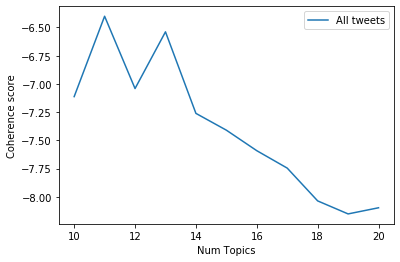

In [12]:
#unigram
from gensim.models import CoherenceModel
unigram = []
unigram_list = []
for index, i in text.iterrows():
    unigram=[]
    for word in i['processed'].split():
        unigram.append(word)
    unigram_list.append(unigram)
data_words = [i for i in unigram_list]
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
#coherence score
limit=21; start=10; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values,label='All tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')

In [13]:
from pprint import pprint
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=11, random_state=0,
                                            alpha='auto', per_word_topics=True)
pprint(lda_model.print_topics(num_words=30))

INFO:gensim.models.ldamodel:using autotuned alpha, starting with [0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909]
INFO:gensim.models.ldamodel:using symmetric eta at 0.09090909090909091
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 6248 documents, updating model once every 2000 documents, evaluating perplexity every 6248 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/6248
INFO:gensim.models.ldamodel:optimized alpha [0.08164306, 0.07996508, 0.079573445, 0.07595554, 0.07757397, 0.07328093, 0.076842725, 0.08005959, 0.07818925, 0.07792298, 0.07537547]
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 6248 documents
INFO:gensim.models.ldamodel:topic #5 (0.073): 

INFO:gensim.models.ldamodel:topic #4 (0.077): 0.021*"meat" + 0.016*"cellag" + 0.015*"first" + 0.015*"chicken" + 0.014*"congratul" + 0.014*"thank" + 0.012*"shiok" + 0.012*"compani" + 0.010*"cleanmeat" + 0.009*"futureoffood" + 0.009*"announc" + 0.008*"huge" + 0.008*"cellularagricultur" + 0.008*"conf" + 0.008*"think" + 0.008*"total" + 0.007*"job" + 0.007*"food" + 0.007*"check" + 0.007*"investor" + 0.007*"cultiv" + 0.007*"invest" + 0.007*"ventur" + 0.007*"team" + 0.007*"build" + 0.006*"beef" + 0.006*"israel" + 0.006*"clean" + 0.006*"march" + 0.006*"world"
INFO:gensim.models.ldamodel:topic #5 (0.064): 0.016*"meat" + 0.015*"last" + 0.014*"chang" + 0.014*"realli" + 0.012*"fish" + 0.011*"tell" + 0.011*"biotech" + 0.011*"effort" + 0.011*"week" + 0.010*"two" + 0.009*"tuna" + 0.008*"say" + 0.008*"food" + 0.008*"night" + 0.008*"interview" + 0.008*"grown" + 0.008*"product" + 0.008*"month" + 0.008*"peopl" + 0.007*"lab" + 0.007*"built" + 0.007*"know" + 0.006*"call" + 0.006*"think" + 0.006*"programm" 

[(0,
  '0.051*"meat" + 0.033*"cell" + 0.029*"base" + 0.017*"food" + 0.015*"anim" + '
  '0.013*"rais" + 0.012*"plant" + 0.011*"product" + 0.009*"world" + '
  '0.009*"steak" + 0.009*"creat" + 0.008*"make" + 0.008*"use" + 0.008*"impact" '
  '+ 0.008*"million" + 0.007*"cultur" + 0.007*"produc" + 0.007*"consum" + '
  '0.007*"global" + 0.006*"beyond" + 0.006*"grown" + 0.006*"compani" + '
  '0.006*"environment" + 0.006*"fish" + 0.006*"first" + 0.006*"farm" + '
  '0.006*"work" + 0.006*"clean" + 0.006*"fund" + 0.006*"grow"'),
 (1,
  '0.067*"meat" + 0.020*"anim" + 0.015*"cultur" + 0.014*"industri" + '
  '0.013*"plantbas" + 0.012*"end" + 0.010*"global" + 0.010*"plant" + '
  '0.009*"grow" + 0.009*"lab" + 0.008*"grown" + 0.008*"new" + 0.008*"via" + '
  '0.008*"food" + 0.008*"cell" + 0.008*"sustain" + 0.008*"seafood" + '
  '0.007*"product" + 0.007*"clean" + 0.007*"mission" + 0.007*"wild" + '
  '0.006*"invest" + 0.006*"popular" + 0.006*"vegan" + 0.006*"need" + '
  '0.006*"leather" + 0.006*"way" + 0.0

In [14]:
def check(word):
    if word in stop_words:
        print(word, 'is a stopword')
    else:
        print(word,'is not a stopword')

In [15]:
check('would')

would is not a stopword
